# Memorization vs Generalization

Neuronale Netze gehören mittlerweile zum Standard-Repertoire des Maschienllen Lernens. Wir erwarten von ihnen, dass sie "einfach lernen". Doch was genau ist mit diesem Begiff eigentlich gemeint? 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization".
- _Generalisierung_: Aus den Trainingsdaten werden Features extrahiert, mit deren Hilfe unbekannte Daten entsprechend klassifiziert werden.

[Beleg?] 

In der Regel erwartet man bei dem Begriff _lernen_ zweiteres. Das Modell soll mit den Trainingsdaten lernen, zusammenhänge und Regeln zu erkennen und auf neue, ungesehene Daten anwenden können. 

In diesem Notebook werden wir uns jedoch mal mit dem ersteren beschäftigen – der Memorization. Auch hierbei leisten DNN durchaus erstaunliches und ein Verständnis dieser Thematik hilft dabei Netze zu entwickeln die besser generalisieren können. 

## Kapazität 

Jedes mathmatische Modell bestetht aus einer Anzahl bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. \cite{Deep Learning}



In [7]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

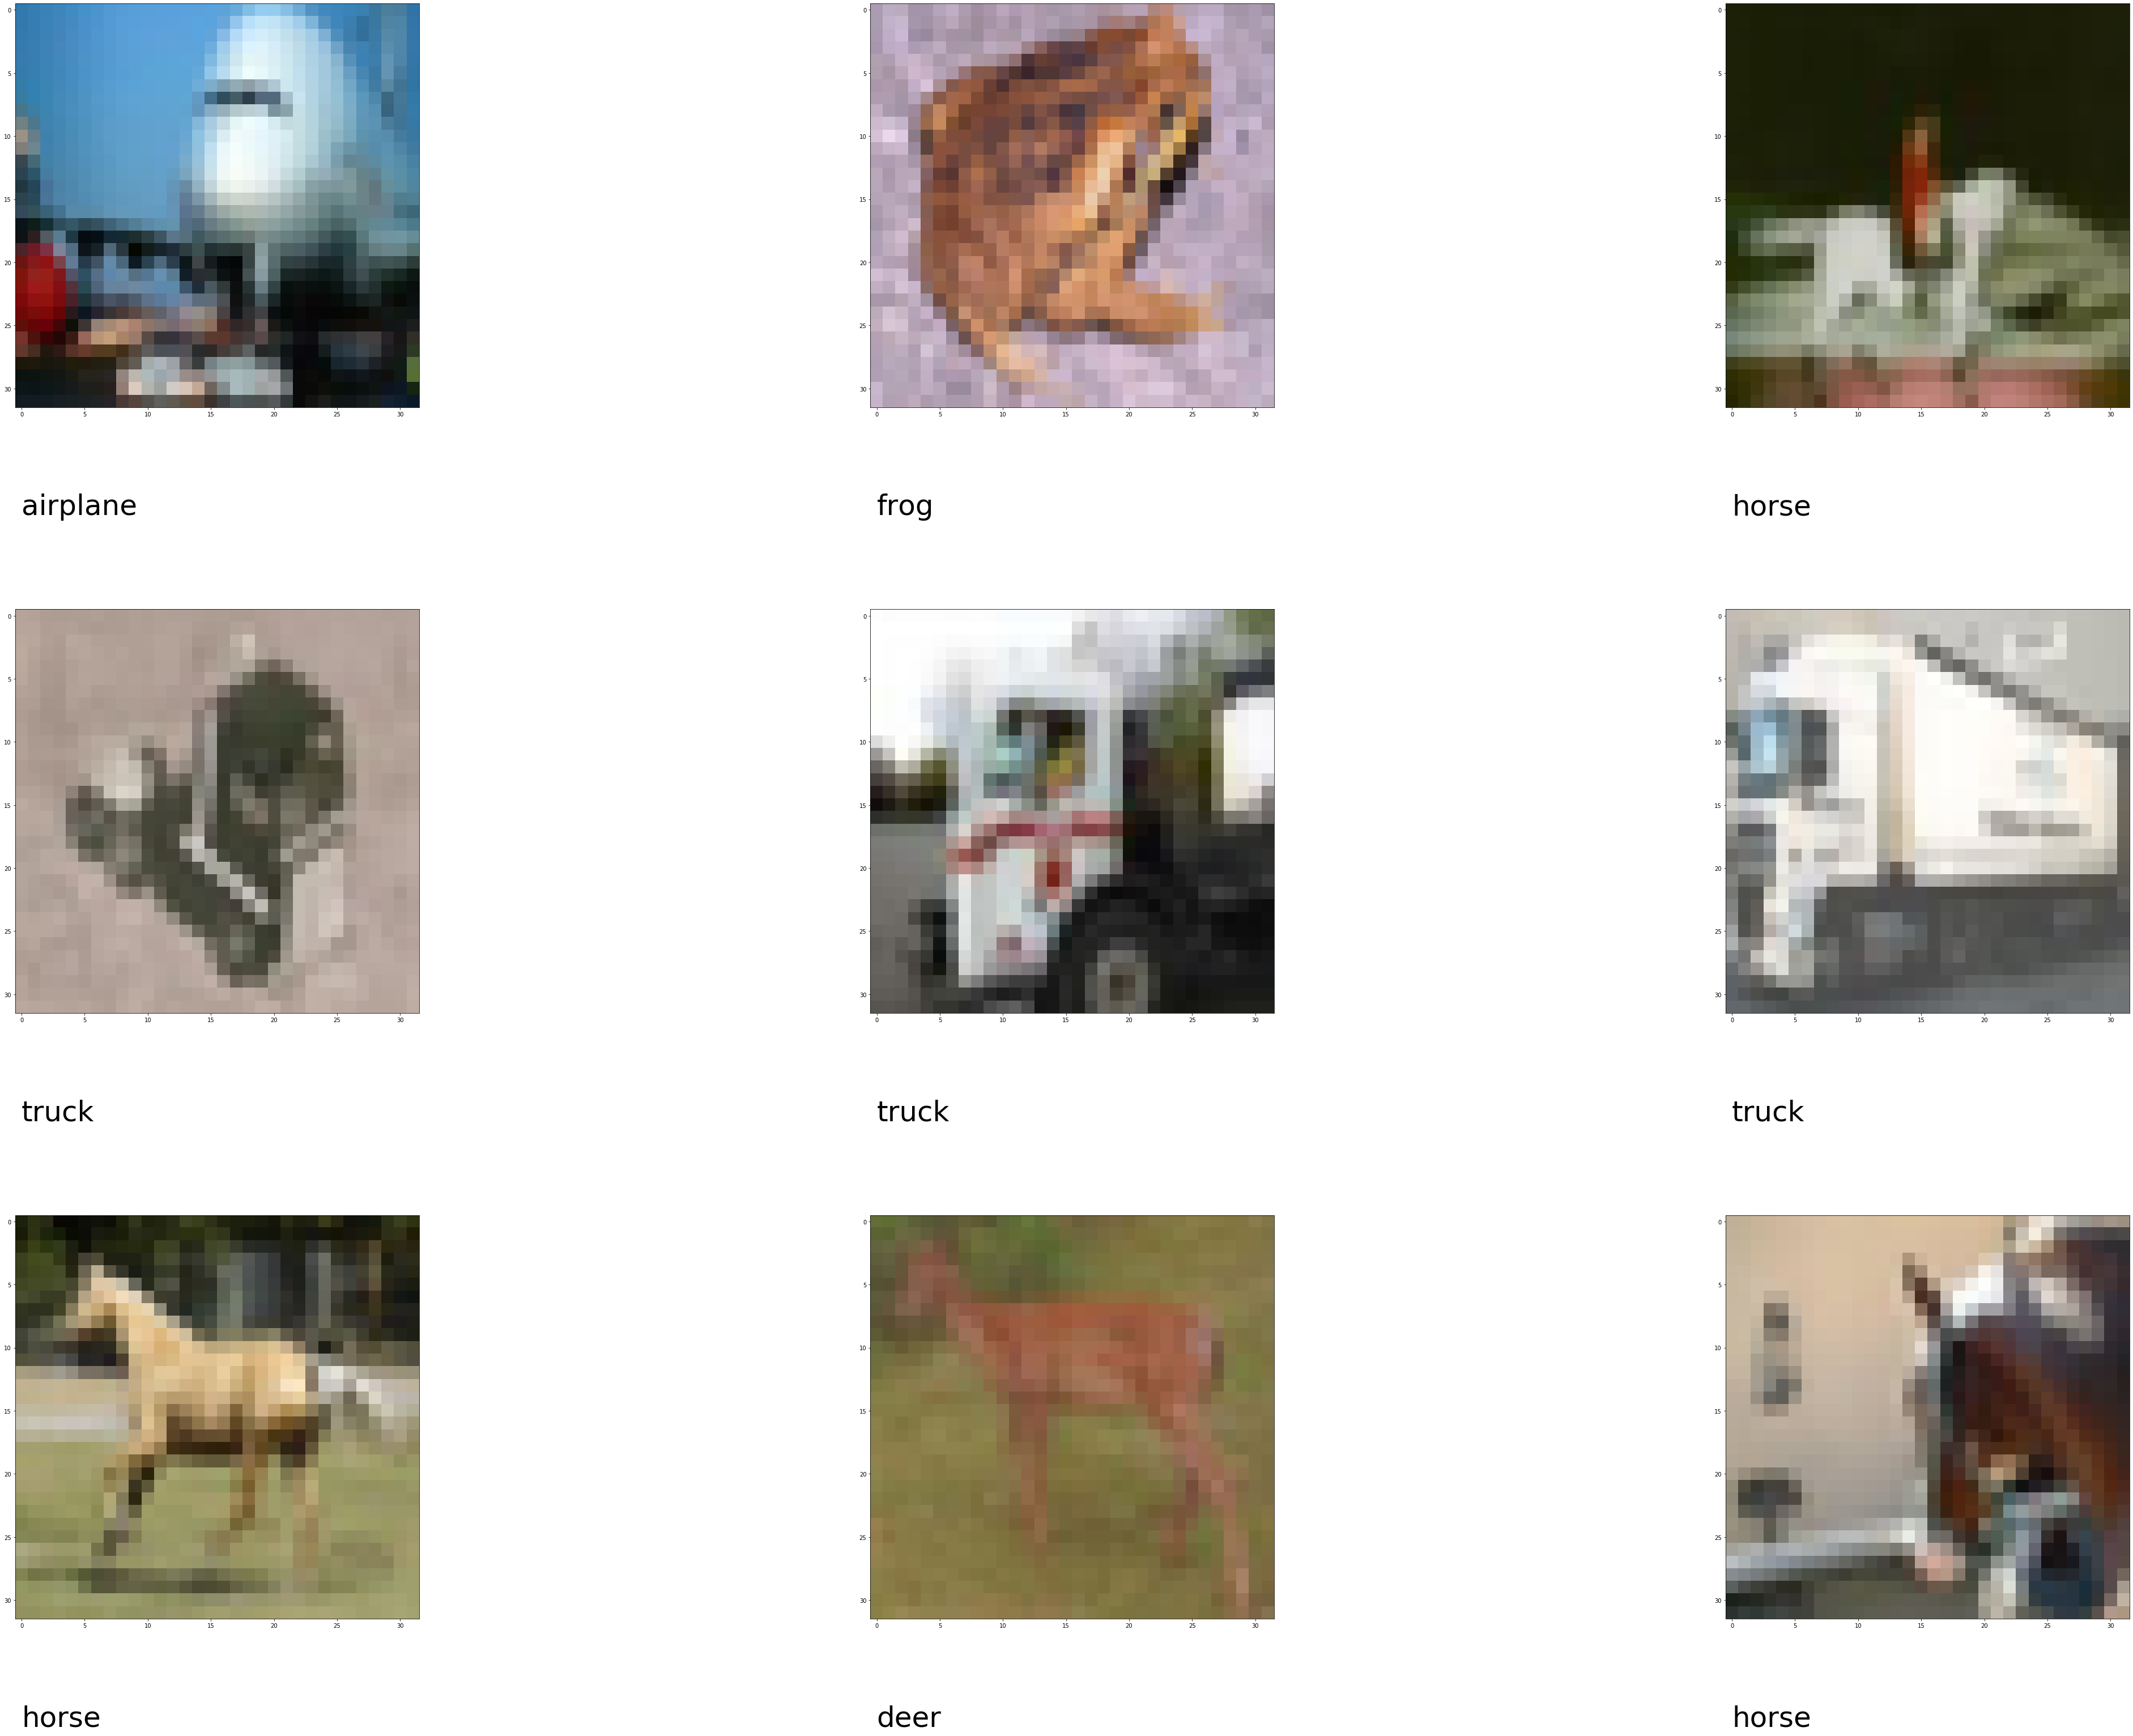

In [8]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [9]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [10]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [11]:
def create_model(conv1, conv2, conv3, dropout, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    if dropout:
        model.add(Dropout(dropout))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if dropout:
            model.add(Dropout(dropout))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if dropout:
            model.add(Dropout(dropout))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    pyplot.legend(loc='lower right')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')
    pyplot.legend(loc='lower right')

    
def create_or_load_model(name, model_params, train_func):
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.json'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        
        model = load_model(model_path)
        with open(history_path) as file:
            history = json.load(file)
    else:
        model = create_model(*model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'w') as file:
            json.dump(history.history, file)
            history = history.history
    return (model, history)

## Tests

Wir teste ein sehr kleines Netz, welches nicht in der Lage ist, die Features ausreichend zu abstrahieren, aber nach vielen Episoden irgendwann trotzdem genug Kapazität hat, um die Daten zu erinnern. 

In [12]:
model_small, history_small = create_or_load_model('small', (3, 0, 0, False, 128), lambda model: model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY)))



Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 4s 74us/step - loss: 2.1031 - acc: 0.2267 - val_loss: 1.9153 - val_acc: 0.3195
Epoch 2/200
50000/50000 [==============================] - 3s 69us/step - loss: 1.8386 - acc: 0.3478 - val_loss: 1.7618 - val_acc: 0.3799
Epoch 3/200
50000/50000 [==============================] - 3s 68us/step - loss: 1.7221 - acc: 0.3925 - val_loss: 1.6732 - val_acc: 0.4092
Epoch 4/200
50000/50000 [==============================] - 3s 69us/step - loss: 1.6399 - acc: 0.4246 - val_loss: 1.6115 - val_acc: 0.4356
Epoch 5/200
50000/50000 [==============================] - 3s 69us/step - loss: 1.5802 - acc: 0.4468 - val_loss: 1.5796 - val_acc: 0.4462
Epoch 6/200
50000/50000 [==============================] - 4s 70us/step - loss: 1.5397 - acc: 0.4607 - val_loss: 1.5340 - val_acc: 0.4547
Epoch 7/200
50000/50000 [==============================] - 3s 69us/step - loss: 1.5051 - acc: 0.4719 - val_loss: 1.5147 - 

50000/50000 [==============================] - 3s 68us/step - loss: 0.7388 - acc: 0.7449 - val_loss: 1.5552 - val_acc: 0.5385
Epoch 60/200
50000/50000 [==============================] - 3s 66us/step - loss: 0.7330 - acc: 0.7470 - val_loss: 1.5520 - val_acc: 0.5419
Epoch 61/200
50000/50000 [==============================] - 3s 64us/step - loss: 0.7198 - acc: 0.7499 - val_loss: 1.5566 - val_acc: 0.5402
Epoch 62/200
50000/50000 [==============================] - 3s 66us/step - loss: 0.7111 - acc: 0.7543 - val_loss: 1.5881 - val_acc: 0.5402
Epoch 63/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.6966 - acc: 0.7595 - val_loss: 1.6308 - val_acc: 0.5344
Epoch 64/200
50000/50000 [==============================] - 3s 67us/step - loss: 0.6878 - acc: 0.7616 - val_loss: 1.6565 - val_acc: 0.5352
Epoch 65/200
50000/50000 [==============================] - 3s 67us/step - loss: 0.6804 - acc: 0.7640 - val_loss: 1.6375 - val_acc: 0.5398
Epoch 66/200
50000/50000 [==============

Epoch 118/200
50000/50000 [==============================] - 3s 67us/step - loss: 0.2355 - acc: 0.9182 - val_loss: 3.3724 - val_acc: 0.4992
Epoch 119/200
50000/50000 [==============================] - 3s 65us/step - loss: 0.2292 - acc: 0.9215 - val_loss: 3.4356 - val_acc: 0.4986
Epoch 120/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.2179 - acc: 0.9253 - val_loss: 3.4539 - val_acc: 0.5013
Epoch 121/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.2177 - acc: 0.9246 - val_loss: 3.4925 - val_acc: 0.4993
Epoch 122/200
50000/50000 [==============================] - 3s 69us/step - loss: 0.2213 - acc: 0.9238 - val_loss: 3.5375 - val_acc: 0.5001
Epoch 123/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.2038 - acc: 0.9294 - val_loss: 3.5716 - val_acc: 0.5035
Epoch 124/200
50000/50000 [==============================] - 3s 67us/step - loss: 0.1939 - acc: 0.9338 - val_loss: 3.6125 - val_acc: 0.4962
Epoch 125/200
50000/

50000/50000 [==============================] - 3s 67us/step - loss: 0.0352 - acc: 0.9920 - val_loss: 4.9368 - val_acc: 0.4930
Epoch 177/200
50000/50000 [==============================] - 3s 69us/step - loss: 0.0228 - acc: 0.9961 - val_loss: 5.0163 - val_acc: 0.4907
Epoch 178/200
50000/50000 [==============================] - 3s 67us/step - loss: 0.0197 - acc: 0.9970 - val_loss: 4.9884 - val_acc: 0.4938
Epoch 179/200
50000/50000 [==============================] - 3s 69us/step - loss: 0.0195 - acc: 0.9969 - val_loss: 5.0417 - val_acc: 0.4957
Epoch 180/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.0146 - acc: 0.9979 - val_loss: 5.0336 - val_acc: 0.4961
Epoch 181/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.0109 - acc: 0.9989 - val_loss: 5.0828 - val_acc: 0.4950
Epoch 182/200
50000/50000 [==============================] - 3s 68us/step - loss: 0.0362 - acc: 0.9913 - val_loss: 5.0933 - val_acc: 0.4896
Epoch 183/200
50000/50000 [=======

Parameter: 99,890
Final Accuracy: 0.99978; Final Validation Accuracy: 0.4961


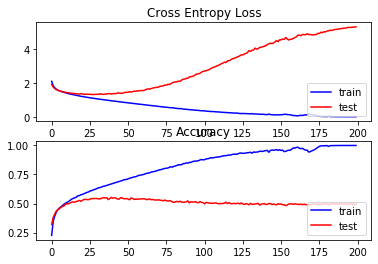

In [13]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

Es zeigt sich, dass ein kleines Netz mit 33 576 Parametern nicht in der Lage ist, die Daten ausreichend zu generalisieren, aber trotzdem nach genug Trainingsepisoden die 50 000 Trainingsdaten erinnern kann. 

Als nächstes ein Netz einer "normalen" Größe, welches in der Lage ist, die CIFAR10 Challange in einem ausreichenden Maß zu meistern.

In [14]:
model_normal, history_normal = create_or_load_model('normal', (32, 64, 128, False, 512), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 160us/step - loss: 1.7011 - acc: 0.3858 - val_loss: 1.4559 - val_acc: 0.4693
Epoch 2/100
50000/50000 [==============================] - 8s 151us/step - loss: 1.3651 - acc: 0.5098 - val_loss: 1.3844 - val_acc: 0.5036
Epoch 3/100
50000/50000 [==============================] - 8s 152us/step - loss: 1.2172 - acc: 0.5712 - val_loss: 1.1996 - val_acc: 0.5780
Epoch 4/100
50000/50000 [==============================] - 8s 151us/step - loss: 1.0908 - acc: 0.6187 - val_loss: 1.1036 - val_acc: 0.6079
Epoch 5/100
50000/50000 [==============================] - 8s 152us/step - loss: 0.9904 - acc: 0.6552 - val_loss: 1.0593 - val_acc: 0.6289
Epoch 6/100
50000/50000 [==============================] - 8s 152us/step - loss: 0.9044 - acc: 0.6837 - val_loss: 0.9714 - val_acc: 0.6624
Epoch 7/100
50000/50000 [==============================] - 8s 152us/step - loss: 0.8323 - acc: 0.7102 - val_loss: 0.

50000/50000 [==============================] - 8s 152us/step - loss: 7.9872e-05 - acc: 1.0000 - val_loss: 2.3031 - val_acc: 0.7158
Epoch 59/100
50000/50000 [==============================] - 8s 153us/step - loss: 7.7589e-05 - acc: 1.0000 - val_loss: 2.3074 - val_acc: 0.7163
Epoch 60/100
50000/50000 [==============================] - 8s 151us/step - loss: 7.5322e-05 - acc: 1.0000 - val_loss: 2.3112 - val_acc: 0.7164
Epoch 61/100
50000/50000 [==============================] - 8s 152us/step - loss: 7.3449e-05 - acc: 1.0000 - val_loss: 2.3155 - val_acc: 0.7158
Epoch 62/100
50000/50000 [==============================] - 8s 151us/step - loss: 7.1370e-05 - acc: 1.0000 - val_loss: 2.3197 - val_acc: 0.7165
Epoch 63/100
50000/50000 [==============================] - 8s 151us/step - loss: 6.9572e-05 - acc: 1.0000 - val_loss: 2.3228 - val_acc: 0.7168
Epoch 64/100
50000/50000 [==============================] - 8s 150us/step - loss: 6.7853e-05 - acc: 1.0000 - val_loss: 2.3271 - val_acc: 0.7162
Epoch

Parameter: 1,341,226
Final Accuracy: 1.0; Final Validation Accuracy: 0.7166


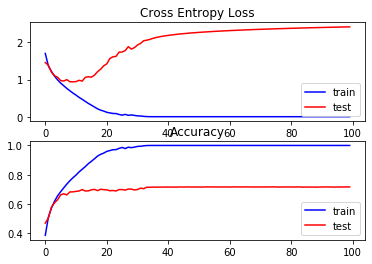

In [15]:
print("Parameter: {:,}".format(model_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_normal['acc'][-1], history_normal['val_acc'][-1]))
plot_summary(history_normal)

Dieses Netz ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels als Y-Daten genutzt werden.

In [16]:
model_random, history_random = create_or_load_model('random', (32, 64, 128, False, 512), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64,  validation_data=(testX, testY)))


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 157us/step - loss: 2.3100 - acc: 0.0978 - val_loss: 2.3029 - val_acc: 0.0879
Epoch 2/100
50000/50000 [==============================] - 8s 151us/step - loss: 2.3030 - acc: 0.1026 - val_loss: 2.3009 - val_acc: 0.1096
Epoch 3/100
50000/50000 [==============================] - 8s 151us/step - loss: 2.3020 - acc: 0.1039 - val_loss: 2.3009 - val_acc: 0.1354
Epoch 4/100
50000/50000 [==============================] - 7s 149us/step - loss: 2.3014 - acc: 0.1080 - val_loss: 2.2996 - val_acc: 0.1116
Epoch 5/100
50000/50000 [==============================] - 8s 152us/step - loss: 2.3007 - acc: 0.1099 - val_loss: 2.3005 - val_acc: 0.0999
Epoch 6/100
50000/50000 [==============================] - 8s 151us/step - loss: 2.2999 - acc: 0.1123 - val_loss: 2.3046 - val_acc: 0.0889
Epoch 7/100
50000/50000 [==============================] - 7s 150us/step - loss: 2.2988 - acc: 0.1142 - val_loss: 2.

50000/50000 [==============================] - 8s 151us/step - loss: 0.2947 - acc: 0.9017 - val_loss: 7.5571 - val_acc: 0.1004
Epoch 60/100
50000/50000 [==============================] - 8s 151us/step - loss: 0.2324 - acc: 0.9220 - val_loss: 7.6006 - val_acc: 0.1012
Epoch 61/100
50000/50000 [==============================] - 8s 150us/step - loss: 0.2387 - acc: 0.9217 - val_loss: 7.8184 - val_acc: 0.0965
Epoch 62/100
50000/50000 [==============================] - 8s 151us/step - loss: 0.2377 - acc: 0.9214 - val_loss: 7.9558 - val_acc: 0.1039
Epoch 63/100
50000/50000 [==============================] - 8s 152us/step - loss: 0.1979 - acc: 0.9348 - val_loss: 8.0210 - val_acc: 0.0985
Epoch 64/100
50000/50000 [==============================] - 8s 151us/step - loss: 0.2046 - acc: 0.9327 - val_loss: 8.0515 - val_acc: 0.0975
Epoch 65/100
50000/50000 [==============================] - 7s 150us/step - loss: 0.1695 - acc: 0.9438 - val_loss: 8.0715 - val_acc: 0.1080
Epoch 66/100
50000/50000 [=======

Parameter: 1,341,226
Final Accuracy: 0.987; Final Validation Accuracy: 0.0987


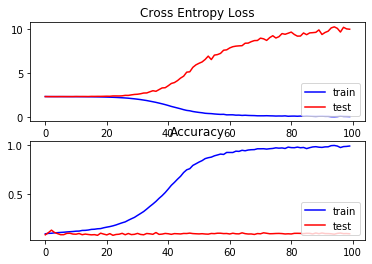

In [17]:
print("Parameter: {:,}".format(model_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_random['acc'][-1], history_random['val_acc'][-1]))
plot_summary(history_random)

## Vergleiche

Im folgenden Diagramm wird die Accuracy der Validationsets über 100 Episoden dargestellt.

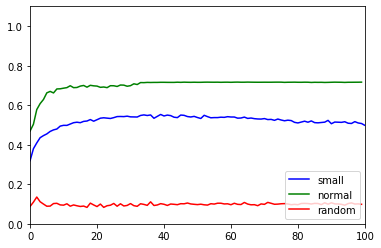

In [18]:
pyplot.plot(history_small['val_acc'], color='blue', label='small')
pyplot.plot(history_normal['val_acc'], color='green', label='normal')
pyplot.plot(history_random['val_acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Wenig überraschend ist die Performance des randomisierten Modells bei knapp 10%, was bei 10 Klassen genau der zu erwartenten Wahrscheinlichkeit einer rein zufälligen Klassenzuordnung entspricht. Das Modell hat aus den Trainingsdaten also keine Regeln zur Generalisierung ableiten können.

Das kleine Modell erreicht mit seinen 99k Parametern nur eine generalisierungs Performance von knapp 50%. Auch nach sehr vielen Episoden steigt diese Leistung nicht weiter an. 

Das folgende Diagramm vergleicht die Accuracy der Trainingsdaten der 3 Versuche miteinander.

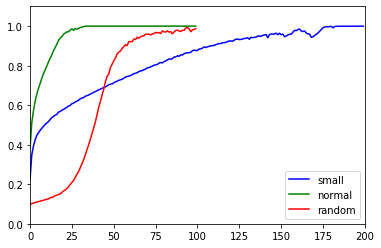

In [19]:
pyplot.plot(history_small['acc'], color='blue', label='small')
pyplot.plot(history_normal['acc'], color='green', label='normal')
pyplot.plot(history_random['acc'], color='red', label='random')
pyplot.axis([0, 200, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Hier ergibt sich ein interessanteres Bild. Alle Modele sind in der Lage, die Klassifikation der Daten nahezu vollständig zu erinnern. Auch das Modell, welches die Daten mit randomisierten Klassen zum Training bekommen hat, ist nach einer langsamen Anfangsphase relativ schnell in der Lage die Daten zu erinnern. der Großteil des "auswendig lernens" passiert innerhalb von nur 25 Episoden. Eine ähnlich lange Zeit benötigt auch das "normale" Modell, nur dass hier die Erinnerung schon nach 25 Episoden fast abgeschlossen ist. 


[Erinnerung zusammen mit lernen, deshalb schneller]

## Overfitting

Overfitting bezeichnet die Überanpassung eines Modells auf die Trainingsdaten. 
Die Fähigkeit von DNNs Daten "auswendig zu lernen" kann auch zu einem Nachteil werden. 

- Statt generalisieren
- nicht erwünscht, da generalisierung abnimmt
- zu viele trainingsepisoden
- zu große kapazität

## Regularization

In den üblichen DL-Anwendungen ist dieses Overfitting nicht gewollt und 

### Regularization Normal

In [20]:
model_reg_normal, history_reg_normal = create_or_load_model('reg_normal', (32, 64, 128, 0.2, 512), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

W0724 18:56:37.547195 139894859732800 deprecation.py:506] From /home/robin/wvin/.venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 196us/step - loss: 1.7527 - acc: 0.3673 - val_loss: 1.5938 - val_acc: 0.4544
Epoch 2/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.3912 - acc: 0.4972 - val_loss: 1.4005 - val_acc: 0.5522
Epoch 3/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.2364 - acc: 0.5569 - val_loss: 1.2336 - val_acc: 0.5880
Epoch 4/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.1182 - acc: 0.6022 - val_loss: 1.1634 - val_acc: 0.6346
Epoch 5/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.0244 - acc: 0.6385 - val_loss: 1.0827 - val_acc: 0.6467
Epoch 6/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.9588 - acc: 0.6629 - val_loss: 1.0182 - val_acc: 0.6578
Epoch 7/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.8908 - acc: 0.6866 - val_loss: 0

50000/50000 [==============================] - 9s 185us/step - loss: 0.0436 - acc: 0.9848 - val_loss: 0.8972 - val_acc: 0.7784
Epoch 60/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.0457 - acc: 0.9834 - val_loss: 0.8746 - val_acc: 0.7838
Epoch 61/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.0445 - acc: 0.9841 - val_loss: 0.8998 - val_acc: 0.7776
Epoch 62/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.0438 - acc: 0.9851 - val_loss: 0.9025 - val_acc: 0.7814
Epoch 63/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.0407 - acc: 0.9863 - val_loss: 0.8783 - val_acc: 0.7840
Epoch 64/100
50000/50000 [==============================] - 9s 187us/step - loss: 0.0416 - acc: 0.9853 - val_loss: 0.9149 - val_acc: 0.7809
Epoch 65/100
50000/50000 [==============================] - 9s 186us/step - loss: 0.0365 - acc: 0.9874 - val_loss: 0.9520 - val_acc: 0.7738
Epoch 66/100
50000/50000 [=======

Parameter: 1,341,226
Final Accuracy: 0.99272; Final Validation Accuracy: 0.7873


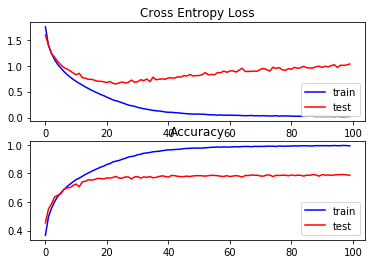

In [21]:
print("Parameter: {:,}".format(model_reg_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_normal['acc'][-1], history_reg_normal['val_acc'][-1]))
plot_summary(history_reg_normal)

### Regularization random

In [22]:
model_reg_random, history_reg_random = create_or_load_model('reg_random', (32, 64, 128, 0.2, 512), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64, validation_data=(testX, testY)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 195us/step - loss: 2.3104 - acc: 0.1010 - val_loss: 2.3045 - val_acc: 0.0887
Epoch 2/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.3032 - acc: 0.1032 - val_loss: 2.3037 - val_acc: 0.1160
Epoch 3/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.3025 - acc: 0.1063 - val_loss: 2.3037 - val_acc: 0.0936
Epoch 4/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.3022 - acc: 0.1074 - val_loss: 2.3031 - val_acc: 0.0948
Epoch 5/100
50000/50000 [==============================] - 9s 185us/step - loss: 2.3020 - acc: 0.1055 - val_loss: 2.3025 - val_acc: 0.1029
Epoch 6/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.3016 - acc: 0.1088 - val_loss: 2.3035 - val_acc: 0.1140
Epoch 7/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.3015 - acc: 0.1081 - val_loss: 2

50000/50000 [==============================] - 9s 184us/step - loss: 2.0669 - acc: 0.2542 - val_loss: 2.3894 - val_acc: 0.0895
Epoch 60/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.0467 - acc: 0.2653 - val_loss: 2.3565 - val_acc: 0.1120
Epoch 61/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.0281 - acc: 0.2714 - val_loss: 2.3857 - val_acc: 0.1015
Epoch 62/100
50000/50000 [==============================] - 9s 184us/step - loss: 2.0067 - acc: 0.2810 - val_loss: 2.3950 - val_acc: 0.1043
Epoch 63/100
50000/50000 [==============================] - 9s 184us/step - loss: 1.9860 - acc: 0.2914 - val_loss: 2.3919 - val_acc: 0.1037
Epoch 64/100
50000/50000 [==============================] - 9s 184us/step - loss: 1.9675 - acc: 0.2990 - val_loss: 2.4019 - val_acc: 0.1100
Epoch 65/100
50000/50000 [==============================] - 9s 184us/step - loss: 1.9461 - acc: 0.3085 - val_loss: 2.4188 - val_acc: 0.1020
Epoch 66/100
50000/50000 [=======

Parameter: 1,341,226
Final Accuracy: 0.7411; Final Validation Accuracy: 0.0998


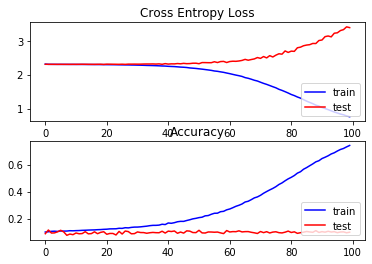

In [23]:
print("Parameter: {:,}".format(model_reg_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_random['acc'][-1], history_reg_random['val_acc'][-1]))
plot_summary(history_reg_random)